# Comparación de volatilidades

In [2]:
pip install --upgrade yfinance

   ---------------------------------------- 0.0/108.7 kB ? eta -:--:--
   ------------------------------------- -- 102.4/108.7 kB 3.0 MB/s eta 0:00:01
   ---------------------------------------- 108.7/108.7 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.40
    Uninstalling yfinance-0.2.40:
      Successfully uninstalled yfinance-0.2.40
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
## Dependencias 
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [12]:
tsla_data=yf.download('TSLA', start='2020-01-01', end='2025-01-01')
tsla_data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2020-01-02,28.684000,28.713333,28.114000,28.299999,142981500
2020-01-03,29.534000,30.266666,29.128000,29.366667,266677500
2020-01-06,30.102667,30.104000,29.333332,29.364668,151995000
2020-01-07,31.270666,31.441999,30.224001,30.760000,268231500
2020-01-08,32.809334,33.232666,31.215334,31.580000,467164500


In [13]:
## Datos y descarga

# Configurar el manejo de fechas
end_date = datetime.now()
start_date = end_date - timedelta(days=365*2)  # 2 años de datos

# Intentar descargar datos con manejo de errores
try:
    spy = yf.download('SPY', start=start_date, end=end_date, progress=False, auto_adjust=False, multi_level_index=False)
    if spy.empty:
        raise ValueError("No se pudieron obtener datos para SPY")
except Exception as e:
    print(f"Error al descargar datos: {e}")
    exit()

# Verificar que tenemos todos los datos necesarios
required_columns = ['Open', 'High', 'Low', 'Close']
if not all(col in spy.columns for col in required_columns):
    print("Faltan columnas necesarias en los datos")
    exit()

In [14]:
spy.head()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2023-02-21,388.136444,399.089996,404.160004,398.820007,403.059998,82655900
2023-02-22,387.601532,398.540009,401.130005,397.019989,399.519989,83742300
2023-02-23,389.663361,400.660004,402.200012,396.250000,401.559998,96242400
2023-02-24,385.500824,396.380005,397.250000,393.640015,395.420013,108194400
2023-02-27,386.813782,397.730011,401.290009,396.750000,399.869995,80444700


In [15]:
##Funciones

# Función para calcular las diferentes volatilidades
def calculate_volatilities(df, window=20):
    result_df = df.copy()
    
    try:
        # Close-to-Close
        result_df['returns'] = result_df['Close'].pct_change()
        result_df['close_to_close'] = result_df['returns'].rolling(window=window).std()
        
        # Parkinson - Corregida
        result_df['parkinson'] = np.sqrt(
            result_df['High'].div(result_df['Low']).apply(np.log).pow(2).rolling(window).mean() / (4 * np.log(2))
        )
        
        # Garman-Klass
        result_df['garman_klass'] = np.sqrt(
            (0.5 * np.log(result_df['High']/result_df['Low']).pow(2) -
             (2*np.log(2)-1) * np.log(result_df['Close']/result_df['Open']).pow(2)
            ).rolling(window).mean()
        )
        
        # Rogers-Satchell
        result_df['rogers_satchell'] = np.sqrt(
            (np.log(result_df['High']/result_df['Close']) * np.log(result_df['High']/result_df['Open']) +
             np.log(result_df['Low']/result_df['Close']) * np.log(result_df['Low']/result_df['Open'])
            ).rolling(window).mean()
        )
        
        # GKYZ
        result_df['gkyz'] = np.sqrt(
            (np.log(result_df['High']/result_df['Low']).pow(2) * 0.511 -
             np.log(result_df['Close']/result_df['Open']).pow(2) * 0.019 -
             np.log(result_df['High']/result_df['Open']) * np.log(result_df['Low']/result_df['Open']) * 2 * 0.383
            ).rolling(window).mean()
        )
        
        # Yang-Zhang
        result_df['overnight_vol'] = np.log(result_df['Open']/result_df['Close'].shift()).pow(2).rolling(window).mean()
        result_df['open_close_vol'] = np.log(result_df['Close']/result_df['Open']).pow(2).rolling(window).mean()
        result_df['rogers_satchell_vol'] = result_df['rogers_satchell'].pow(2)
        
        k = 0.34/(1.34 + (window + 1)/(window - 1))
        result_df['yang_zhang'] = np.sqrt(result_df['overnight_vol'] + k * result_df['open_close_vol'] + 
                                        (1-k) * result_df['rogers_satchell_vol'])
        
    except Exception as e:
        print(f"Error al calcular volatilidades: {e}")
        return None
    
    return result_df

# Calcular volatilidades
spy_with_vol = calculate_volatilities(spy, window=20)


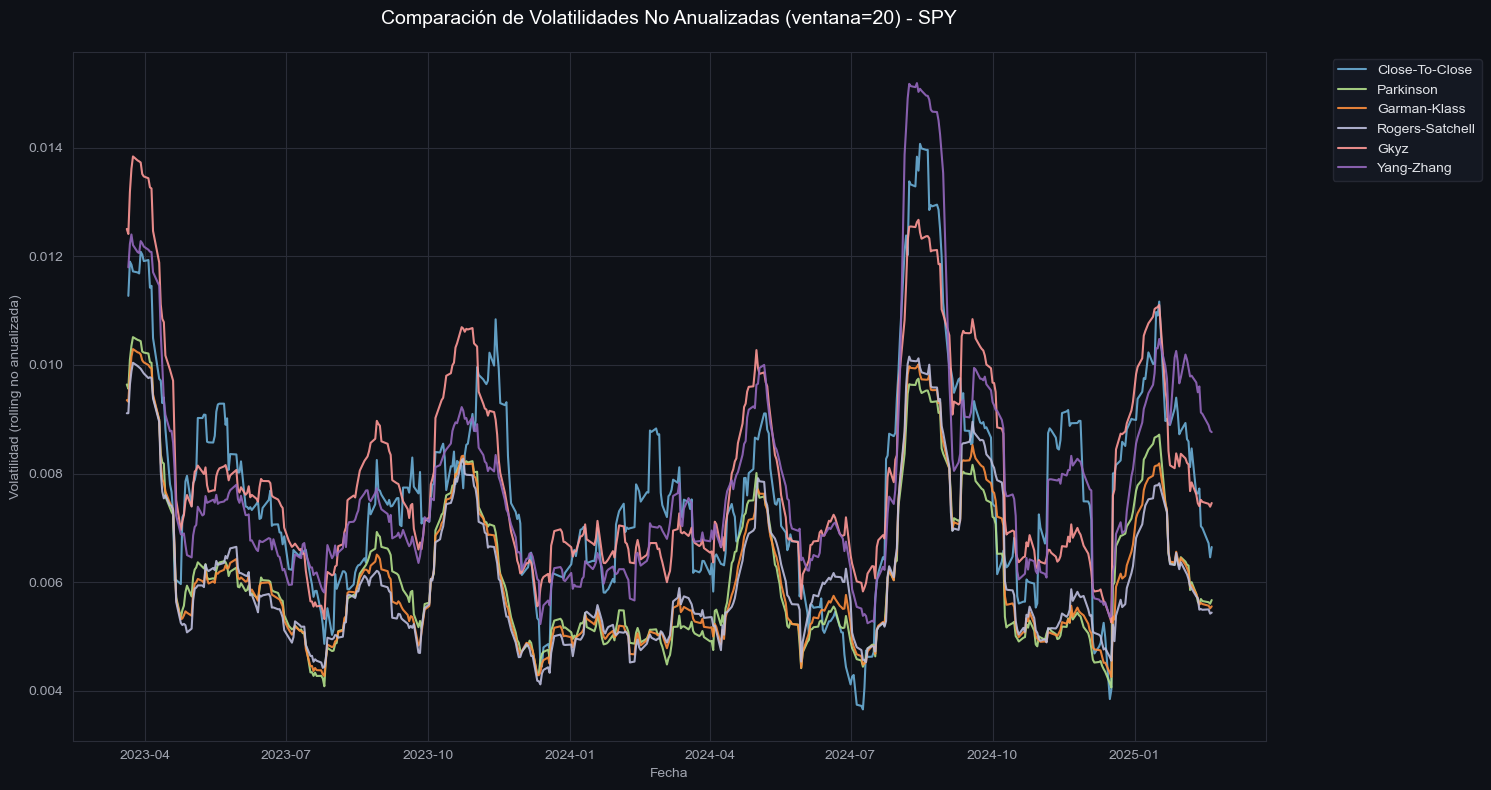

In [16]:
#Graficar. Utilizamos una paleta personalizada.

if spy_with_vol is not None:
    # Configurar el estilo visual mejorado
    plt.style.use('dark_background')
    sns.set_style("darkgrid", {
        "axes.facecolor": "#0e1117",
        "figure.facecolor": "#0e1117",
        "grid.color": "#2a2d38",
        "axes.edgecolor": "#2a2d38"
    })
    
    # Crear una paleta de colores personalizada
    palette = [
        "#6baed6",  # Azul suave
        "#b2df8a",  # Verde claro
        "#fd8d3c",  # Naranja cálido
        "#bcbddc",  # Lavanda
        "#ff9896",  # Coral claro
        "#9467bd"   # Púrpura
    ]
    
    # Crear figura
    plt.figure(figsize=(15, 8))

    # Graficar las volatilidades con la nueva paleta
    volatility_columns = ['close_to_close', 'parkinson', 'garman_klass', 
                         'rogers_satchell', 'gkyz', 'yang_zhang']
    
    for col, color in zip(volatility_columns, palette):
        plt.plot(spy_with_vol.index, spy_with_vol[col], 
                 label=col.replace('_', '-').title(), 
                 color=color, 
                 linewidth=1.5,
                 alpha=0.9)

    # Configurar el gráfico
    plt.title('Comparación de Volatilidades No Anualizadas (ventana=20) - SPY', 
             pad=20, color='white', fontsize=14)
    plt.xlabel('Fecha', color='#a1a5b0')
    plt.ylabel('Volatilidad (rolling no anualizada)', color='#a1a5b0')
    
    # Personalizar ejes
    ax = plt.gca()
    ax.tick_params(colors='#a1a5b0')
    ax.spines['bottom'].set_color('#2a2d38')
    ax.spines['left'].set_color('#2a2d38')
    
    # Leyenda mejorada
    legend = plt.legend(bbox_to_anchor=(1.05, 1), 
                       loc='upper left',
                       frameon=True,
                       facecolor='#161a25',
                       edgecolor='#2a2d38',
                       fontsize=10)
    
    for text in legend.get_texts():
        text.set_color('#e1e3e8')

    # Ajustar los márgenes
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()
else:
    print("No se pudo generar el gráfico debido a errores en el cálculo de volatilidades")

Comparar las volatilidades no anualizadas:

1. Interpretación más directa:
- Las volatilidades no anualizadas muestran la variabilidad real observada en los datos diarios
- Evita la distorsión que puede introducir la multiplicación por √252 (días de trading)
- Permite ver más claramente las diferencias metodológicas entre los distintos estimadores

2. Precisión en el análisis de corto plazo:
- Los movimientos diarios y semanales son más visibles
- No se amplifica artificialmente la magnitud de los movimientos
- Es más útil para traders y analistas que operan en horizontes cortos

3. Comparabilidad estadística:
- La anualización asume que la volatilidad se escala uniformemente con el tiempo (√t)
- Esta asunción no siempre es válida, especialmente en mercados con comportamientos no normales
- Las medidas no anualizadas permiten comparar directamente la eficiencia de cada estimador


4. Flexibilidad en el análisis:
- Si se necesita anualizar posteriormente, siempre se puede multiplicar por √252
- Permite aplicar diferentes factores de anualización según el mercado o activo
- Facilita la comparación entre mercados con diferentes días de trading por año

Por estas razones, especialmente cuando se están comparando diferentes metodologías de estimación de volatilidad, es preferible trabajar con los valores no anualizados y solo anualizar cuando sea necesario para reportes o comparaciones específicas que lo requieran.

# Cálculo de Volatilidades

## 1. Close-to-Close Volatility
$$
\sigma_{cc} = \sqrt{\frac{1}{N} \sum_{t=1}^{N} r_t^2}
$$
donde $ r_t = \ln\left(\frac{C_t}{C_{t-1}}\right) $ es el retorno logarítmico diario.

## 2. Parkinson Volatility
$$
\sigma_{p} = \sqrt{\frac{1}{4N \ln(2)} \sum_{t=1}^{N} \left( \ln\left(\frac{H_t}{L_t}\right) \right)^2 }
$$
donde $  H_t$  y $  L_t $  son los precios más altos y más bajos del día, respectivamente.

## 3. Garman-Klass Volatility
$$
\sigma_{gk} = \sqrt{\frac{1}{N} \sum_{t=1}^{N} \left( \frac{1}{2} \ln^2\left(\frac{H_t}{L_t}\right) - (2\ln(2)-1) \ln^2\left(\frac{C_t}{O_t}\right) \right)}
$$
donde $  O_t $  y $  C_t $  son los precios de apertura y cierre del día.

## 4. Rogers-Satchell Volatility
$$
\sigma_{rs} = \sqrt{\frac{1}{N} \sum_{t=1}^{N} \left( \ln\left(\frac{H_t}{C_t}\right) \ln\left(\frac{H_t}{O_t}\right) + \ln\left(\frac{L_t}{C_t}\right) \ln\left(\frac{L_t}{O_t}\right) \right)}
$$

## 5. Garman-Klass-Yang-Zhang (GKYZ) Volatility
$$
\sigma_{gkyz} = \sqrt{\frac{1}{N} \sum_{t=1}^{N} \left( 0.511 \ln^2\left(\frac{H_t}{L_t}\right) - 0.019 \ln^2\left(\frac{C_t}{O_t}\right) - 0.383 \ln\left(\frac{H_t}{O_t}\right) \ln\left(\frac{L_t}{O_t}\right) \right)}
$$

## 6. Yang-Zhang Volatility
$$
\sigma_{yz} = \sqrt{\sigma_o^2 + k\sigma_c^2 + (1-k)\sigma_{rs}^2}
$$
donde:
- $  \sigma_o^2 $  es la varianza de la volatilidad overnight:
  $$
  \sigma_o^2 = \frac{1}{N} \sum_{t=1}^{N} \ln^2\left(\frac{O_t}{C_{t-1}}\right)
  $$
- $  \sigma_c^2 $  es la varianza de los retornos open-to-close:
  $$
  \sigma_c^2 = \frac{1}{N} \sum_{t=1}^{N} \ln^2\left(\frac{C_t}{O_t}\right)
  $$
- $  \sigma_{rs}^2 $  es la volatilidad de Rogers-Satchell elevada al cuadrado.
- $  k $  es un factor de ajuste:
  $$
  k = \frac{0.34}{1.34 + \frac{N+1}{N-1}}
  $$

